# Final Project: Facial Keypoints Detection

by Michael Berger, Andre Fernandes, Vivian Lu, Sam Tosaria and Pauline Wang.

Our project related to the kaggle [facial keypoint detection competition](https://www.kaggle.com/c/facial-keypoints-detection). We need to build a well-performing machine learning system to determine the x and y coordinates of keypoints in an image of a human face (e.g. left eye corner). There are up to 30 keypoints. The problem is a regression problem and in this task we have up to 30 regression outputs to predict (x and y of 15 labels). We will especially focus on practicing **Convolutional Neural Networks**. As baseline model we use xyz. The metric used on teh kaggle competition is the root mean squared error (RMSE) defined as:

$RMSE = \sqrt{ \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2}$

Our analysis is structured as follows:
- We first load the libraries we use as well as the testing and training data.
- We then transform the data in a shape and format useable for us.
- We plot a couple of training images and associated keypoints.
- ...

## Exploration Data Analysis

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are missing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

We first import all the libaries required to build our model: 

In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from sklearn.metrics import classification_report

from keras.models import Sequential 
from keras.layers import BatchNormalization, Conv2D, Dense, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

#PW: added warning ignore
import warnings
warnings.filterwarnings('ignore')

In [84]:
#Here we extract the data files (NOTE: please enter data path)
path_train = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/training.csv'
path_test = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/test.csv'

df_train_dev= pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
labels = df_train.iloc[:, 0:30] #creates labels for facial feature position
#labels.columns #check column names

In [85]:
# processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = df_train_dev.loc[:,'Image'].T
kaggle_train = kaggle_train.astype(str)
kaggle_train = kaggle_train.str.split(" ", expand = True) 
kaggle_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176


In [86]:
# processing test data such that each pixel has its own column,
# merging it then with the ImageId column
image_test = df_test.loc[:,'Image'].T
image_test = image_test.astype(str)
image_test = image_test.str.split(" ", expand = True)
kaggle_test = pd.DataFrame(df_test.loc[:,'ImageId']).join(image_test)
#kaggle_test.head()

In [87]:
#EDA Codes - Please feel free to look at the data. Below are some code options. 

# Missing values kaggle_training?
#kaggle_train.columns[kaggle_train.isna().any()].tolist()

# Missing values in labels?
labels.columns[labels.isna().any()].tolist()

#kaggle_train.shape
#kaggle_test.shape
#kaggle_train.describe()
#labels.describe()

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [10]:
#this tells us how manyd data points are missing
labels.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

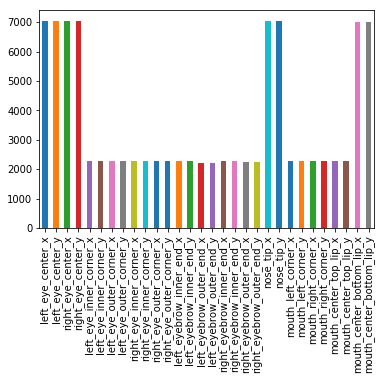

In [88]:
#this chart tells us only about 2000 images have all 30 keypoints labeled
labels.describe().loc['count'].plot.bar()

In [89]:
#percentage missing per label
#we see the hisghest missing labels are.....
labels.isnull().sum() / labels.shape[0]

left_eye_center_x            0.001419
left_eye_center_y            0.001419
right_eye_center_x           0.001844
right_eye_center_y           0.001844
left_eye_inner_corner_x      0.677827
left_eye_inner_corner_y      0.677827
left_eye_outer_corner_x      0.678394
left_eye_outer_corner_y      0.678394
right_eye_inner_corner_x     0.678252
right_eye_inner_corner_y     0.678252
right_eye_outer_corner_x     0.678252
right_eye_outer_corner_y     0.678252
left_eyebrow_inner_end_x     0.677969
left_eyebrow_inner_end_y     0.677969
left_eyebrow_outer_end_x     0.684352
left_eyebrow_outer_end_y     0.684352
right_eyebrow_inner_end_x    0.677969
right_eyebrow_inner_end_y    0.677969
right_eyebrow_outer_end_x    0.682792
right_eyebrow_outer_end_y    0.682792
nose_tip_x                   0.000000
nose_tip_y                   0.000000
mouth_left_corner_x          0.678110
mouth_left_corner_y          0.678110
mouth_right_corner_x         0.677969
mouth_right_corner_y         0.677969
mouth_center

We have missing values in the labels... how to deal with that?
PW: Let's deal with the missing values in the image augementation section. 

### Plotting some images with face points

Next we take a look at the images and the labels in our dataset

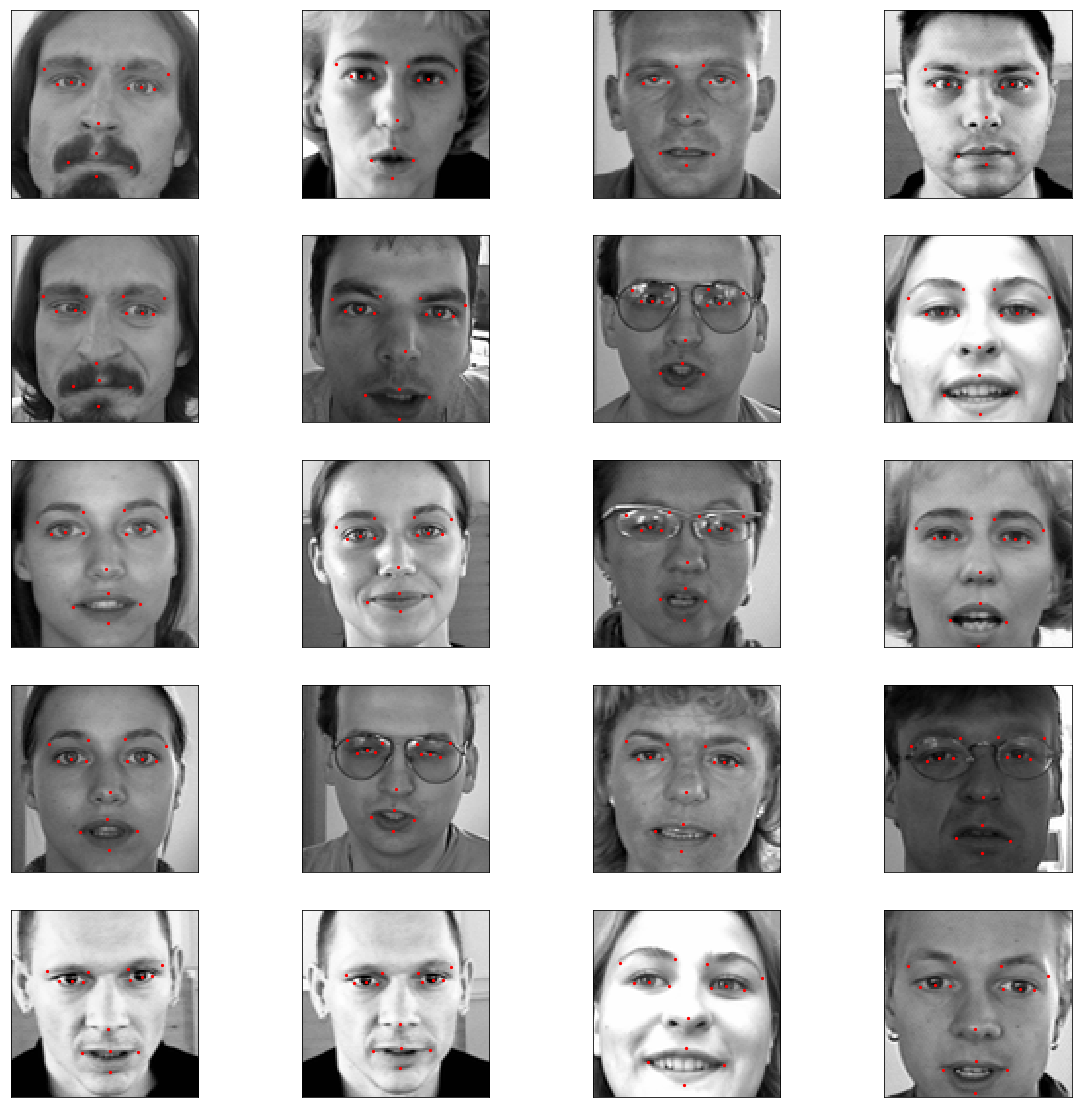

In [90]:
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

## CNN Base Model##

We first drop all the data containg missing key points values and run a model to predict accuracy and loss ratio.  This leave us about 2140 high quality images. 

In [91]:
hq_image=df_train_dev.dropna() #we drop all images with mising value which left us with 2140 images

In [92]:
def string_image(string):
    """This functions converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

In [93]:
X = np.stack([string_image(string) for string in hq_image['Image']]).astype(np.float)[:, :, :, np.newaxis]
y = np.vstack(hq_image[hq_image.columns[:-1]].values)
#print(X.shape, X.dtype)
#print(y.shape, y.dtype)

In [94]:
X_train = X / 255.
output_pipe = make_pipeline(MinMaxScaler(feature_range=(-1, 1)))
y_train = output_pipe.fit_transform(y)

In [95]:
base_model = Sequential()#isntantiate a base sequential model
base_model.add(Dense(100, activation="relu", input_shape=(96*96,)))
base_model.add(Activation('relu'))
base_model.add(Dense(30))

In [96]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
base_model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = base_model.fit(X_train.reshape(y_train.shape[0], -1), y_train, validation_split=0.3, shuffle=True, epochs=epochs, batch_size=20)

Train on 1498 samples, validate on 642 samples
Epoch 1/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.0434 - acc: 0.3071 - val_loss: 0.0706 - val_acc: 0.1028
Epoch 2/50
1498/1498 [==============================] - 1s 788us/step - loss: 0.0298 - acc: 0.3818 - val_loss: 0.0677 - val_acc: 0.0950
Epoch 3/50
1498/1498 [==============================] - 1s 773us/step - loss: 0.0270 - acc: 0.4379 - val_loss: 0.0656 - val_acc: 0.0935
Epoch 4/50
1498/1498 [==============================] - 1s 822us/step - loss: 0.0254 - acc: 0.4399 - val_loss: 0.0640 - val_acc: 0.1121
Epoch 5/50
1498/1498 [==============================] - 1s 716us/step - loss: 0.0237 - acc: 0.4446 - val_loss: 0.0653 - val_acc: 0.1168
Epoch 6/50
1498/1498 [==============================] - 1s 730us/step - loss: 0.0219 - acc: 0.4746 - val_loss: 0.0657 - val_acc: 0.0935
Epoch 7/50
1498/1498 [==============================] - 1s 737us/step - loss: 0.0206 - acc: 0.4980 - val_loss: 0.0643 - val_acc: 0.1090
Epo

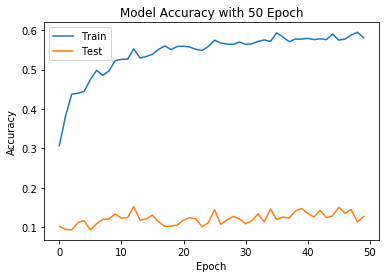

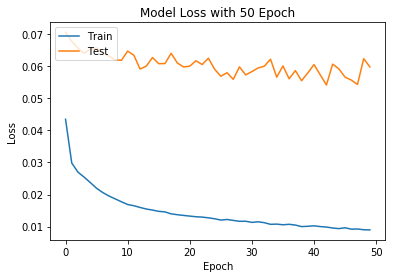

In [97]:
#We plot the history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy with 50 Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# We plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss with 50 Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

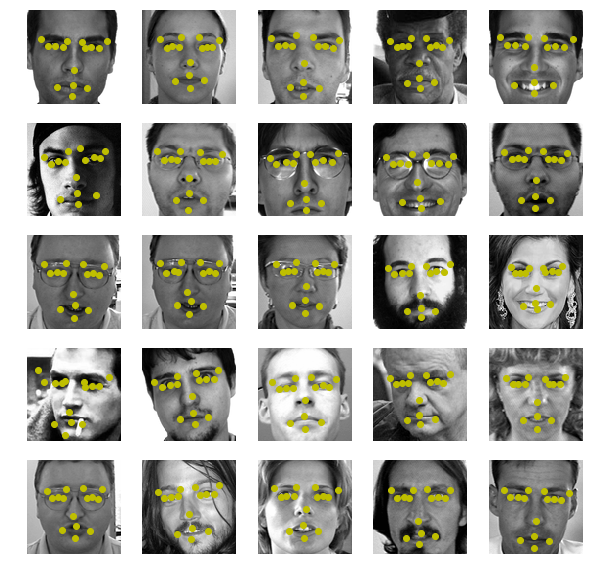

In [98]:
# we plot the prediction with facial images

img = X_train[0, :, :, :].reshape(1, -1)
predictions = base_model.predict(img)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'yo')
        ax.axis('off')
        
        
plot_faces_with_keypoints_and_predictions(base_model)

### Section Summary ###

<add some description of the - PW to fill out>

From the accuracy and loss plots above, it's apparent that our model overfits with disproportional train and test losses. In the next sections, we will explore methods to improve our model by augmenting the image data.  
    
 

## Image Augumentation

We expeirment with below method for improving our model performance:

I. create a mask

II. blah blah....

III. blah blah...

## ANDRE's CODE BELOW

In [100]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
# i = 0
# for batch in datagen.flow(kaggle_train[1], batch_size=1):
#   plt.figure(i)
#   imgplot = plt.imshow(array_to_img(batch[0]))
#   i += 1
#   if i % 5 == 0:
#     break

In [ ]:
# i = 0
# for batch in datagen.flow(kaggle_train, batch_size=1):
#   plt.figure(i)
#   imgplot = plt.imshow(array_to_img(batch[0]))
#   i += 1
#   if i % 5 == 0:
#     break

In [ ]:
# x_img

In [ ]:
# testin = img_to_array(x_img)
# testin = testin.reshape((1,)+testin.shape)
# testin
# new_img = datagen.flow(testin, batch_size=1)

In [ ]:
# new_img

In [ ]:
# new_img = datagen.flow(x_img, batch_size=1)

In [51]:
kaggle_train

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176
5,167,169,170,167,156,145,106,68,52,24,...,107,105,103,97,86,86,82,78,86,95
6,109,109,125,141,145,139,120,81,45,34,...,94,115,145,139,114,110,117,117,108,103
7,178,177,178,179,179,179,181,185,188,184,...,59,70,75,78,93,119,120,100,72,74
8,164,158,118,76,66,69,59,53,43,31,...,49,56,44,33,45,60,72,85,102,138
9,226,227,225,224,221,220,215,210,210,208,...,109,113,112,113,116,116,119,118,114,113


In [15]:
?norm_img

Object `norm_img` not found.


NameError: name 'create_mask' is not defined

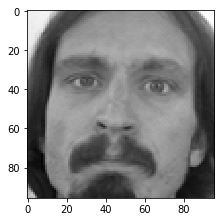

In [27]:
position = 1
fig = plt.figure(figsize = (20, 20))
batch_size=3


for index in range(5):
#     print(index)
    sub = fig.add_subplot(5, 4, position)
    x_img = np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96))
    plt.imshow(x_img, cmap = 'gray')
    new_img = img_to_array(x_img)
    
    array_test2= np.reshape(np.array(create_mask(get_target_coordinates(pd.DataFrame(labels.iloc[index,:])))), (96, 96))
    print(new_img.shape, array_test2.shape)
    
    #new_img2 = new_img #np.dstack([new_img,new_img])
    #print(new_img2.shape)
    new_img = new_img.reshape((1,)+new_img.shape)
    new_img2 = array_test2.reshape(new_img.shape)
    #print(new_img.shape, new_img2.shape)
    i=0
    for batch in datagen.flow(new_img, batch_size=batch_size, seed=index):
        #print(batch)
#         norm_img = datagen.flow(new_img, batch_size=batch_size, seed=index)
#         mask_img = datagen.flow(new_img2, batch_size=batch_size, seed=index)
        #print(norm_img)
#         print(i*index+i+2)
        sub = fig.add_subplot(5, 4, (batch_size+1)*index+i+2)
        plt.imshow(array_to_img(batch[0]))
        #plt.imshow(array_to_img(new_img[i]), cmap = 'gray')
        i += 1
        if i % batch_size == 0:
            break
            
    for batch2 in datagen.flow(new_img2, batch_size=batch_size, seed=index):
        #print(batch)
#         norm_img = datagen.flow(new_img, batch_size=batch_size, seed=index)
#         mask_img = datagen.flow(new_img2, batch_size=batch_size, seed=index)
#         print(norm_img)
# #         print(i*index+i+2)
#         sub = fig.add_subplot(5, 4, (batch_size+1)*index+i+2)
#         plt.imshow(array_to_img(batch[0]))
        #plt.imshow(array_to_img(new_img[i]), cmap = 'gray')
        view2 = batch2[0]
        i += 1
        if i % batch_size == 0:
            break
#     for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
#         if coord == None:
#             continue
#         else:
#             plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 4

plt.show()

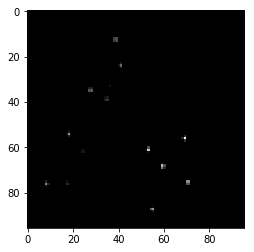

In [366]:
plt.imshow(array_to_img(view2))

In [362]:
v2

NameError: name 'v2' is not defined

In [17]:
new_img2 = np.zeros(96*96)
new_img2[0]

0.0

In [18]:
new_img2[6375] = 1

In [19]:
array_test.flatten()

NameError: name 'array_test' is not defined

In [296]:
def re_round(li, _prec=5):
     try:
        return round(li, _prec)
     except TypeError:
        return type(li)(re_round(x, _prec) for x in li)

def get_target_coordinates(labels):
    x = labels.iloc[1::2].values.tolist()
    y = labels.iloc[::2].values.tolist()
    #print(type(x))
    target_array = list(zip(x,y))
    target_array = re_round(target_array,0)
    return target_array

def create_mask(coords):
    new_img = np.zeros(96*96)
    for iland, (ix,iy) in enumerate(coords):
        tar_val = int(iy[0]*96 + ix[0])
        #print(iland, int(ix[0]), int(iy[0]))
        new_img[tar_val] = iland
    return(new_img)

array_test = get_target_coordinates(pd.DataFrame(labels.iloc[0]))
array_test2 = create_mask(array_test)

In [298]:
print(array_test2)

[0. 0. 0. ... 0. 0. 0.]


In [259]:
array_test

[([39.0], [66.0]),
 ([36.0], [30.0]),
 ([40.0], [60.0]),
 ([40.0], [73.0]),
 ([37.0], [36.0]),
 ([37.0], [23.0]),
 ([29.0], [57.0]),
 ([32.0], [80.0]),
 ([29.0], [40.0]),
 ([30.0], [16.0]),
 ([57.0], [44.0]),
 ([80.0], [61.0]),
 ([77.0], [29.0]),
 ([73.0], [43.0]),
 ([84.0], [43.0])]

In [147]:

    
re_round(array_test,0)

[([39.0], [66.0]),
 ([36.0], [30.0]),
 ([40.0], [60.0]),
 ([40.0], [73.0]),
 ([37.0], [36.0]),
 ([37.0], [23.0]),
 ([29.0], [57.0]),
 ([32.0], [80.0]),
 ([29.0], [40.0]),
 ([30.0], [16.0]),
 ([57.0], [44.0]),
 ([80.0], [61.0]),
 ([77.0], [29.0]),
 ([73.0], [43.0]),
 ([84.0], [43.0])]

In [258]:
def get_ymask(img, xys):
    '''
    img : (N width, N height, N channel) array of image
    xys : A list containint tuple of (x,y) coordinate od landmark. For example:
    
    xys = [(x1,y1),
           (x2,y2),
           (x3,y3),
           (x4,y4),
           ...] 
    '''
    yimg = np.zeros((img[0],img[1],1))
    print(yimg.shape)
    yimg[:] = -1
    for iland, (ix,iy) in enumerate(xys):
        #print(ix, iy, iland)
        yimg[int(iy[0]),int(ix[0])] = iland
    return(np.dstack([img,yimg]))

yimg = get_ymask((96,96,1),get_target_coordinates(pd.DataFrame(labels.iloc[0])))
print("The dimension of the original image {} -> masked image {}".format((96,96,1),yimg.shape))

<class 'list'>
(96, 96, 1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [153]:
get_target_coordinates(pd.DataFrame(labels.iloc[0]))

<class 'list'>


[([39.00227], [66.03356]),
 ([36.42168], [30.22701]),
 ([39.64742], [59.58208]),
 ([39.97], [73.13035]),
 ([37.3894], [36.35657]),
 ([37.3894], [23.45287]),
 ([29.03365], [56.95326]),
 ([32.22814], [80.22713]),
 ([29.00232], [40.22761]),
 ([29.64747], [16.35638]),
 ([57.0668], [44.42057]),
 ([79.97017], [61.19531]),
 ([77.38899], [28.6145]),
 ([72.93546], [43.3126]),
 ([84.48577], [43.13071])]

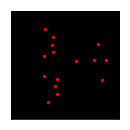

In [216]:
pic = plt.figure(figsize=(2,2))
pic.tight_layout(True)
black_size= 96*96
plt.imshow(np.reshape(np.concatenate((np.zeros(black_size),np.ones(96*96-black_size)),axis=0), (96, 96)), cmap = 'gray')
for iland, (ix,iy) in enumerate(array_test):
    plt.gca().scatter(ix, iy, c = 'red', s = 5)
plt.xticks([])
plt.yticks([])
plt.show()

In [217]:
pic.savefig('C:/Users/afern/Desktop/Berkeley/foo.png')
image = Image.open('C:/Users/afern/Desktop/Berkeley/foo.png')

In [210]:
?pic

In [234]:
new_img = image.resize((96,96))

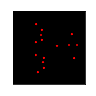

In [239]:
new_img

In [256]:
pd.DataFrame(numpy.array(new_img).flatten()).to_csv("C:/Users/afern/Desktop/Berkeley/foo.csv")

In [202]:
import numpy
 
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.frombuffer( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    print(w, h)
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

from PIL import Image
 
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape

    return buf #Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [ ]:
plt

In [205]:
?pic

In [195]:
numpy.frombuffer( fig.canvas.tostring_argb(), dtype=numpy.uint8 )

(4927824,)

In [224]:
print(new_img.frombytes)

<bound method Image.frombytes of <PIL.Image.Image image mode=RGBA size=96x96 at 0x2C07D4E8B70>>


In [220]:
fig2img(new_img).shape

AttributeError: 'Image' object has no attribute 'canvas'

In [192]:
96*96

9216

In [191]:
plt.imshow(np.reshape(fig2img(pic), (96, 96)), cmap = 'gray')

ValueError: cannot reshape array of size 82944 into shape (96,96)

In [165]:
' '.join(map(str,plt.flatten()))

AttributeError: module 'matplotlib.pyplot' has no attribute 'flatten'

In [136]:
array_test.size

AttributeError: 'list' object has no attribute 'size'

In [131]:
np.reshape(np.zeros(96*96), (96, 96))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [119]:
print(enumerate(array_test))

In [107]:
x_test = (96,96,1)
x_test[0]

96

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(yimg[:,:,3])
plt.title("The mask receives non-negative values at landmarks")
plt.show()

In [62]:
labels.iloc[0]

left_eye_center_x            66.033564
left_eye_center_y            39.002274
right_eye_center_x           30.227008
right_eye_center_y           36.421678
left_eye_inner_corner_x      59.582075
left_eye_inner_corner_y      39.647423
left_eye_outer_corner_x      73.130346
left_eye_outer_corner_y      39.969997
right_eye_inner_corner_x     36.356571
right_eye_inner_corner_y     37.389402
right_eye_outer_corner_x     23.452872
right_eye_outer_corner_y     37.389402
left_eyebrow_inner_end_x     56.953263
left_eyebrow_inner_end_y     29.033648
left_eyebrow_outer_end_x     80.227128
left_eyebrow_outer_end_y     32.228138
right_eyebrow_inner_end_x    40.227609
right_eyebrow_inner_end_y    29.002322
right_eyebrow_outer_end_x    16.356379
right_eyebrow_outer_end_y    29.647471
nose_tip_x                   44.420571
nose_tip_y                   57.066803
mouth_left_corner_x          61.195308
mouth_left_corner_y          79.970165
mouth_right_corner_x         28.614496
mouth_right_corner_y     

In [105]:
def get_target_coordinates(labels):
    x = labels.iloc[1::2].values
    y = labels.iloc[::2].values
    target_array = list(zip(x,y))
    return target_array

array_test = get_target_coordinates(pd.DataFrame(labels.iloc[0]))
array_test

[(array([39.00227368]), array([66.03356391])),
 (array([36.4216782]), array([30.22700752])),
 (array([39.64742256]), array([59.58207519])),
 (array([39.96999699]), array([73.13034586])),
 (array([37.3894015]), array([36.35657143])),
 (array([37.3894015]), array([23.45287218])),
 (array([29.03364812]), array([56.95326316])),
 (array([32.22813835]), array([80.22712782])),
 (array([29.0023218]), array([40.22760902])),
 (array([29.64747068]), array([16.35637895])),
 (array([57.06680301]), array([44.42057143])),
 (array([79.97016541]), array([61.19530827])),
 (array([77.38899248]), array([28.61449624])),
 (array([72.93545865]), array([43.3126015])),
 (array([84.48577444]), array([43.13070677]))]

In [ ]:
x= labels.iloc[:, 0::2].values
y= labels.iloc[:, 1::2].values
labels.iloc[0]

In [80]:
type(labels.iloc[0])

pandas.core.series.Series

In [78]:
x

array([[66.03356391, 30.22700752, 59.58207519, ..., 28.61449624,
        43.3126015 , 43.13070677],
       [64.33293617, 29.9492766 , 58.85617021, ..., 35.12238298,
        46.68459574, 45.46791489],
       [65.05705263, 30.90378947, 59.412     , ..., 33.72631579,
        47.27494737, 47.27494737],
       ...,
       [66.69073171, 31.66641951,         nan, ...,         nan,
                nan, 49.46257171],
       [70.96508235, 30.54328471,         nan, ...,         nan,
                nan, 50.06518588],
       [66.93831111, 31.09605926,         nan, ...,         nan,
                nan, 45.90048   ]])

In [88]:
y

array([[39.00227368, 36.4216782 , 39.64742256, ..., 77.38899248,
        72.93545865, 84.48577444],
       [34.9700766 , 33.44871489, 35.27434894, ..., 76.04765957,
        70.26655319, 85.48017021],
       [34.90964211, 34.90964211, 36.32096842, ..., 72.732     ,
        70.19178947, 78.65936842],
       ...,
       [36.84522146, 39.68504195,         nan, ...,         nan,
                nan, 78.11712   ],
       [39.85366588, 40.77233882,         nan, ...,         nan,
                nan, 79.58644706],
       [43.42450963, 39.52860444,         nan, ...,         nan,
                nan, 82.7730963 ]])

In [67]:
labels[0, 1::2]

TypeError: unhashable type: 'slice'

In [53]:
list(zip(x,y))

30

In [ ]:
plt.imshow(new_img[i], cmap = 'gray')

## Splitting kaggle_train and labels into test, training and development sets

In [ ]:
# How to deal with missing values?

# ignoring them?
index_none_missing = np.sum(np.isfinite(labels), axis = 1) == labels.shape[1]
kaggle_train_no_na = np.asarray(kaggle_train.loc[index_none_missing,:])
kaggle_train_no_na.shape

Ignoring them leads to not having much observations... but a lot of features...

In [ ]:
labels_no_na = np.asarray(labels.loc[index_none_missing,:])
labels_no_na.shape

In [ ]:
shuffle = np.random.permutation(np.arange(kaggle_train_no_na.shape[0]))
X, Y = kaggle_train_no_na[shuffle], labels_no_na[shuffle]

# Split 60% train, 20% dev, 20% test
split_train = 0.6
split_dev_test = 0.5
test = int(X.shape[0]*split_train)
dev = int(X.shape[0]*(1-split_train)*split_dev_test) + test
test_data, test_labels = X[:test], Y[:test]
dev_data, dev_labels = X[test:dev], Y[test:dev]
train_data, train_labels = X[dev:], Y[dev:]

print(test_data.shape, test_labels.shape)
print(dev_data.shape, dev_labels.shape)
print(train_data.shape, train_labels.shape)